<a href="https://colab.research.google.com/github/amFarrouk/OCR_prj/blob/main/simpleCNN_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import pandas as pd
import os
import matplotlib.pyplot as plt
import zipfile
import numpy as np

In [2]:
!wget https://raw.githubusercontent.com/amFarrouk/OCR_prj/main/bdh.zip
!unzip -qq ./bdh.zip 
!rm ./bdh.zip

--2022-01-06 21:18:34--  https://raw.githubusercontent.com/amFarrouk/OCR_prj/main/bdh.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7536168 (7.2M) [application/zip]
Saving to: ‘bdh.zip’

bdh.zip             100%[===================>]   7.19M  --.-KB/s    in 0.08s   

2022-01-06 21:18:34 (85.3 MB/s) - ‘bdh.zip’ saved [7536168/7536168]



In [3]:
!wget https://www.dropbox.com/s/qpagi0h1089kr2f/images_df.csv

--2022-01-06 21:18:39--  https://www.dropbox.com/s/qpagi0h1089kr2f/images_df.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/qpagi0h1089kr2f/images_df.csv [following]
--2022-01-06 21:18:39--  https://www.dropbox.com/s/raw/qpagi0h1089kr2f/images_df.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb856a7a7f0825ee8dc9671fe84.dl.dropboxusercontent.com/cd/0/inline/BdQlJhLcOJnUY_2D0PQ9MIVjrDO46l0VP09Zerj5GRuOWNfCyYw5pRd55MNukOLkw21WxoaM4cEuVYcJrXkbvnsxJUet4DkQ_llgCT1Q2NFh71crXSgNSxhNI_UyVSg8CsDfHNFEr2szH1a3QoA4feHx/file# [following]
--2022-01-06 21:18:39--  https://ucb856a7a7f0825ee8dc9671fe84.dl.dropboxusercontent.com/cd/0/inline/BdQlJhLcOJnUY_2D0PQ9MIVjrDO46l0VP09Zerj5GRuOWNfCyYw5pRd55MNukOLkw21WxoaM4cEuVYcJrXkbvns

In [4]:
images_df=pd.read_csv("./images_df.csv",header=None,names=["img","label"])
images_df["label"]=images_df["label"].apply(lambda x : str(x))
images_df.head()

,img,label
0,ae07_005.bmp,18
1,ae07_011.bmp,17
2,ae07_014.bmp,20
3,ae07_015.bmp,18
4,ae07_022.bmp,12


In [5]:
from sklearn.model_selection import train_test_split

In [6]:
all_x,all_y=images_df["img"],images_df["label"]

xtrain,xtest,ytrain,ytest=train_test_split(all_x,all_y,train_size=0.7,random_state=1,shuffle=True,stratify=all_y)

train_df=pd.DataFrame(xtrain,columns=["img"])
train_df["label"]=ytrain

print("train_data:")
train_df.head()

train_data:


,img,label
5917,de42_040.bmp,9
3036,bi94_028.bmp,8
2993,bi92_016.bmp,13
1429,am10_115.bmp,10
2479,bf52_047.bmp,5


In [7]:
test_df=pd.DataFrame(xtest,columns=["img"])
test_df["label"]=ytest

test_data:


,img,label
19,ae09_020.bmp,12
7509,dq62_022.bmp,1
6562,di45_021.bmp,20
2029,be43_035.bmp,14
6428,di27_005.bmp,19


In [8]:
all_x_test,all_y_test=test_df["img"],test_df["label"]

In [9]:
xtrain,xtest,ytrain,ytest=train_test_split(all_x_test,all_y_test,train_size=0.5,random_state=1,shuffle=True,stratify=all_y_test)

val_df=pd.DataFrame(xtrain,columns=["img"])
val_df["label"]=ytrain

test_df=pd.DataFrame(xtest,columns=["img"])
test_df["label"]=ytest

In [27]:
test_df.head(10)

,img,label
6839,di81_004.bmp,16
6429,di27_013.bmp,18
6185,df18_015.bmp,16
5991,de55_035.bmp,15
1105,aj03_025.bmp,18
1735,aq35_021.bmp,5
1091,ai90_052.bmp,5
6774,di77_044.bmp,4
6601,di47_103.bmp,7
3267,bm14_002.bmp,6


In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [14]:
train_image_gen=ImageDataGenerator(rescale=1.0/255)
val_image_gen=ImageDataGenerator(rescale=1.0/255)

In [15]:
train_image_gen=train_image_gen.flow_from_dataframe(train_df,x_col="img",y_col="label",
                                            directory="./bdh",
                                            batch_size=32,
                                            target_size=(150,850),
                                            color_mode='grayscale',
                                            class_mode='sparse')

Found 5292 validated image filenames belonging to 22 classes.


In [17]:
val_image_gen=val_image_gen.flow_from_dataframe(val_df,x_col="img",y_col="label",
                                            directory="./bdh",
                                            batch_size=32,
                                            target_size=(150,850),
                                            color_mode='grayscale',
                                            class_mode='sparse')

Found 1134 validated image filenames belonging to 22 classes.


In [18]:
import tensorflow as tf

In [19]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 850x150 with 1 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 850, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Reshape((1,-1)),
    # Bidirectional layer of 32 neurons with LSTM
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    # Only 22 output neuron.
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(22, activation='softmax')
])

In [20]:
loss=tf.keras.losses.sparse_categorical_crossentropy
optim=tf.keras.optimizers.Adam()
myCallBack=tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=3)

model.compile(optimizer=optim, loss=loss, metrics=['accuracy'])

_=tf.keras.utils.plot_model(
    model, to_file='./simpleCNN_RNN.png', show_shapes=True, show_layer_names=False,
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 848, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 424, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 422, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 211, 64)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 209, 64)       36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 104, 64)      0

In [22]:
history=model.fit(train_image_gen,epochs=15,steps_per_epoch=165,validation_data=val_image_gen,callbacks=[myCallBack])

Epoch 1/15
165/165 [==============================] - 36s 216ms/step - loss: 0.3319 - accuracy: 0.8875 - val_loss: 0.3698 - val_accuracy: 0.8951
Epoch 2/15
165/165 [==============================] - 36s 216ms/step - loss: 0.1215 - accuracy: 0.9631 - val_loss: 0.2631 - val_accuracy: 0.9206
Epoch 3/15
165/165 [==============================] - 36s 216ms/step - loss: 0.0448 - accuracy: 0.9903 - val_loss: 0.2738 - val_accuracy: 0.9224
Epoch 4/15
165/165 [==============================] - 36s 216ms/step - loss: 0.0124 - accuracy: 0.9983 - val_loss: 0.2630 - val_accuracy: 0.9303
Epoch 5/15
165/165 [==============================] - 36s 216ms/step - loss: 0.0034 - accuracy: 0.9994 - val_loss: 0.2653 - val_accuracy: 0.9365
Epoch 6/15
165/165 [==============================] - 36s 216ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.2329 - val_accuracy: 0.9453
Epoch 7/15
165/165 [==============================] - 36s 216ms/step - loss: 7.1988e-04 - accuracy: 1.0000 - val_loss: 0.2356 - va

In [23]:
from tensorflow.keras.models import load_model

In [24]:
model.save('simpleModelCNNRNN.h5')

In [25]:
#-----------------------------------------------------------------------
# Retrieve a list of list results on training and test data of 1st model
# sets for each training epoch
#-----------------------------------------------------------------------
acc_hist=history.history['accuracy']
val_acc_hist=history.history['val_accuracy']
loss_hist=history.history['loss']
val_loss_hist=history.history['val_loss']

epochs=range(len(acc_hist)) # Get number of epochs

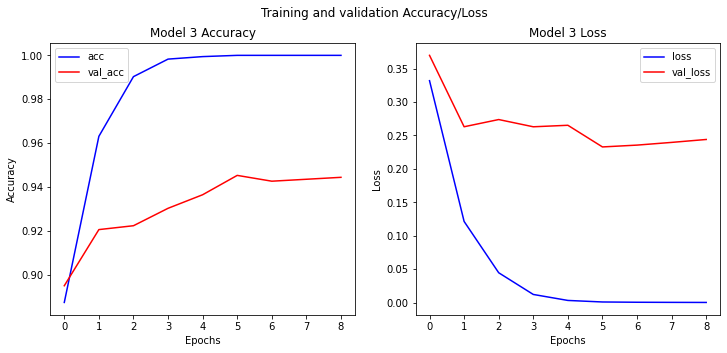

In [26]:
#-----------------------------------------------------------------------
# Plot training and validation accuracy and loss per epoch for 3rd model
#-----------------------------------------------------------------------
fig, (axs1, axs2) = plt.subplots(1, 2,figsize=(12,5),sharey=False)
fig.suptitle('Training and validation Accuracy/Loss')

axs1.set_title('Model 3 Accuracy')
axs1.set(xlabel="Epochs",ylabel="Accuracy")
axs1.plot(epochs, acc_hist,'b',label="acc")
axs1.plot(epochs, val_acc_hist,'r',label="val_acc")
axs1.legend(loc="upper left")

axs2.set_title('Model 3 Loss')
axs2.set(xlabel="Epochs",ylabel="Loss")
axs2.plot(epochs, loss_hist,'b',label="loss")
axs2.plot(epochs, val_loss_hist,'r',label="val_loss")
axs2.legend(loc="upper right")

plt.savefig("model3accloss.png")
plt.show()

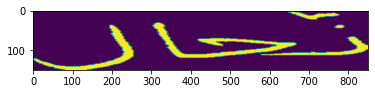

img_batch shape (1, 150, 850, 1)


7

In [28]:
#test place

"""
img	label
6839	di81_004.bmp	16
6429	di27_013.bmp	18
6185	df18_015.bmp	16
5991	de55_035.bmp	15
1105	aj03_025.bmp	18
1735	aq35_021.bmp	5
1091	ai90_052.bmp	5
6774	di77_044.bmp	4
6601	di47_103.bmp	7
3267	bm14_002.bmp	6
"""

#img_path = "chimakh.bmp"

img_path="./bdh/di81_004.bmp"
img = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
img= cv2.resize(img,(850,150))
#img=img/255.0

plt.imshow(img)
plt.show()

img_array = tf.keras.preprocessing.image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)

print("img_batch shape",img_batch.shape)

prediction = model.predict(img_batch)
np.argmax(prediction,axis=1)[0]

In [29]:
train_image_gen.class_indices

{'1': 0,
 '10': 1,
 '11': 2,
 '12': 3,
 '13': 4,
 '14': 5,
 '15': 6,
 '16': 7,
 '17': 8,
 '18': 9,
 '19': 10,
 '2': 11,
 '20': 12,
 '21': 13,
 '22': 14,
 '3': 15,
 '4': 16,
 '5': 17,
 '6': 18,
 '7': 19,
 '8': 20,
 '9': 21}

In [30]:
from sklearn.metrics import accuracy_score

In [97]:
test_image_gen=ImageDataGenerator(rescale=1.0/255)

In [98]:
test_image_gen=test_image_gen.flow_from_dataframe(test_df,x_col="img",y_col="label",
                                            directory="./bdh",
                                            batch_size=32,
                                            target_size=(150,850),
                                            color_mode='grayscale',
                                            class_mode='sparse')

Found 1134 validated image filenames belonging to 22 classes.


In [99]:
true_y=[]
for i in range(1134):
  true_y.append(test_df["label"].iloc[i])

In [101]:
true_y_ind=[]
for x in true_y:
  true_y_ind.append(train_image_gen.class_indices[str(x)])

In [112]:
test_img_name=[]
for i in range(1134):
  test_img_name.append(test_df["img"].iloc[i])

In [115]:
predictions=[]
for name in test_img_name:
  img_path="./bdh/"+name
  img = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
  img= cv2.resize(img,(850,150))

  img_array = tf.keras.preprocessing.image.img_to_array(img)
  img_batch = np.expand_dims(img_array, axis=0)

  prediction = model.predict(img_batch)
  predictions.append(np.argmax(prediction,axis=1)[0])


In [117]:
test_acc = accuracy_score(predictions, true_y_ind)

In [118]:
test_acc

0.9488536155202821